# 07: 正規化層 (Normalization Layers)

このノートブックでは、ディープニューラルネットワークの学習を劇的に安定させ、高速化する革命的なテクニックである「正規化層」について学びます。特に、畳み込みニューラルネットワーク（CNN）で絶大な効果を発揮する**Batch Normalization**と、再帰型ニューラルネットワーク（RNN）やTransformerで広く用いられる**Layer Normalization**に焦点を当てます。

なぜこれらの正規化が必要なのか、その背景にある「内部共変量シフト」という概念から始め、各手法の具体的な計算方法と、それが学習に与える影響を理解します。

**参考論文:**
*   (Batch Normalization) Ioffe, S., & Szegedy, C. (2015). Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift.
*   (Layer Normalization) Ba, J. L., Kiros, J. R., & Hinton, G. E. (2016). Layer Normalization.

**このノートブックで学ぶこと:**
1.  深いネットワークの学習を困難にする「内部共変量シフト」の概念。
2.  Batch Normalizationのアルゴリズム：ミニバッチ単位での正規化、スケール、シフト。
3.  Batch Normalizationの学習時と推論時の振る舞いの違い。
4.  バッチサイズに依存しないLayer Normalizationのアルゴリズム。
5.  Batch NormalizationとLayer Normalizationの計算対象の違いと、その使い分け。
6.  正規化層がもたらす効果（学習の高速化、正則化効果など）。

**前提知識:**
*   ニューラルネットワークの順伝播・逆伝播の基本的な理解。
*   ミニバッチ学習の概念。
*   統計学の基礎知識（平均、分散）。
*   NumPyとMatplotlibの基本的な使い方。

## 1. 必要なライブラリのインポート

In [9]:
import numpy as np
import matplotlib.pyplot as plt

## 2. なぜ正規化が必要か？ - 内部共変量シフト

ディープニューラルネットワークの学習では、各層のパラメータは前の層の出力（アクティベーション）を基に更新されます。これは、ある層から見ると、その**入力データの分布が、学習が進むにつれて刻々と変化していく**ことを意味します。

例えば、第2層は第1層の出力を入力として受け取ります。学習ステップが進み、第1層の重みが更新されると、第2層への入力の分布（平均や分散）も変わってしまいます。この現象を、Batch Normalizationの論文では**内部共変量シフト（Internal Covariate Shift）**と呼んでいます。

この内部共変量シフトが起きると、
*   後続の層は、常に変化する入力分布に適応し続けなければならず、学習が不安定になります。
*   活性化関数が飽和領域（例：Sigmoidの入力が極端な値になる領域）に入りやすくなり、勾配消失を引き起こす可能性があります。
*   学習率などのハイパーパラメータの設定が非常に敏感になり、チューニングが困難になります。

正規化層は、この問題を解決するために、**層への入力の分布を強制的に安定させる（平均0、分散1に近づける）**ことを目的としています。これにより、各層はより安定した入力データ上で学習を進めることができ、ネットワーク全体の学習が高速化・安定化します。

## 3. Batch Normalization (BN)

Batch Normalizationは、その名の通り、**ミニバッチ単位**で入力データの正規化を行います。活性化関数の直前に挿入されるのが一般的です。

### 3.1 Batch Normalizationのアルゴリズム

ミニバッチ $\mathcal{B} = \{x_1, \dots, x_m\}$ に対して、Batch Normalizationは以下の4つのステップで計算されます。

**Step 1: ミニバッチの平均を計算**
$$
\mu_{\mathcal{B}} = \frac{1}{m} \sum_{i=1}^{m} x_i
$$

**Step 2: ミニバッチの分散を計算**
$$
\sigma^2_{\mathcal{B}} = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu_{\mathcal{B}})^2
$$

**Step 3: 正規化**
各入力 $x_i$ を、平均0、分散1になるように正規化します。$\epsilon$ はゼロ除算を防ぐための微小値です。
$$
\hat{x}_i = \frac{x_i - \mu_{\mathcal{B}}}{\sqrt{\sigma^2_{\mathcal{B}} + \epsilon}}
$$

**Step 4: スケールとシフト**
正規化によって常に平均0、分散1の分布に固定してしまうと、モデルの表現力が損なわれる可能性があります。例えば、Sigmoid関数にとっては、入力が原点付近に集中しすぎてしまい、非線形性を活かせなくなるかもしれません。

そこで、正規化された値 $\hat{x}_i$ に対して、学習可能なパラメータ $\gamma$（スケール）と $\beta$（シフト）を用いてアフィン変換を行います。
$$
y_i = \gamma \hat{x}_i + \beta
$$
この $\gamma$ と $\beta$ は、逆伝播によって他の重みと同様に学習されます。これにより、ネットワークは最適な分布のスケールと平均を自ら学習することができます。もし恒等変換が最適であれば、学習によって $\gamma \to \sqrt{\sigma^2_{\mathcal{B}}}$, $\beta \to \mu_{\mathcal{B}}$ となります。

### 3.2 学習時と推論時の違い

Batch Normalizationの重要な点は、学習時と推論時で振る舞いが異なることです。

*   **学習時**: 上記のアルゴリズムの通り、**現在のミニバッチ**の平均と分散を使って正規化を行います。同時に、推論時に使用するための**全データの移動平均（running mean）と移動分散（running variance）**を計算し、保持しておきます。
    $$
    \mu_{running} \leftarrow (1-d) \mu_{running} + d \cdot \mu_{\mathcal{B}} \\
    \sigma^2_{running} \leftarrow (1-d) \sigma^2_{running} + d \cdot \sigma^2_{\mathcal{B}}
    $$
    ここで $d$ は減衰率（momentum）です。

*   **推論時**: 推論時は、バッチという概念がない（あるいはバッチサイズが1）ため、ミニバッチの統計量を使うことはできません。代わりに、学習中に計算しておいた**全データの移動平均と移動分散**を使って正規化を行います。
    $$
    \hat{x} = \frac{x - \mu_{running}}{\sqrt{\sigma^2_{running} + \epsilon}} \\
    y = \gamma \hat{x} + \beta
    $$

### 3.3 Batch Normalizationの効果

*   **学習の高速化**: 内部共変量シフトを抑制することで、より大きな学習率を設定でき、学習が速く進みます。
*   **正則化効果**: ミニバッチごとの統計量で正規化するため、各データは他のデータの影響を受けたノイズを含むことになります。これが一種の正則化として機能し、Dropoutなどの他の正則化手法の必要性を減らすことがあります。
*   **初期値への依存性の低減**: 学習が安定するため、重みの初期値に対してそれほど敏感ではなくなります。

## 4. Layer Normalization (LN)

Batch Normalizationは非常に強力ですが、**バッチサイズが小さい場合**に統計量が不安定になるという欠点があります。また、サンプルごとにシーケンス長が異なるRNNやTransformerのようなモデルには適用が困難です。

Layer Normalizationは、これらの問題を解決するために提案されました。BNがバッチ内のサンプル間で正規化するのに対し、LNは**単一のサンプル内**で正規化を行います。

### 4.1 Layer Normalizationのアルゴリズム

単一のデータサンプル $x$（$H$個の特徴量を持つベクトル）に対して、Layer Normalizationは以下のステップで計算されます。

**Step 1: サンプル内の特徴量の平均を計算**
$$
\mu = \frac{1}{H} \sum_{i=1}^{H} x_i
$$

**Step 2: サンプル内の特徴量の分散を計算**
$$
\sigma^2 = \frac{1}{H} \sum_{i=1}^{H} (x_i - \mu)^2
$$

**Step 3 & 4: 正規化、スケール、シフト**
計算した平均と分散を用いて正規化し、BNと同様に学習可能なパラメータ $\gamma, \beta$ でスケールとシフトを行います。
$$
\hat{x} = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} \\
y = \gamma \hat{x} + \beta
$$

**重要な違い**: LNの計算は**単一のサンプル内で完結**しており、他のサンプル（バッチ）の情報に依存しません。そのため、バッチサイズが1でも問題なく動作し、学習時と推論時で計算方法が変わることもありません。

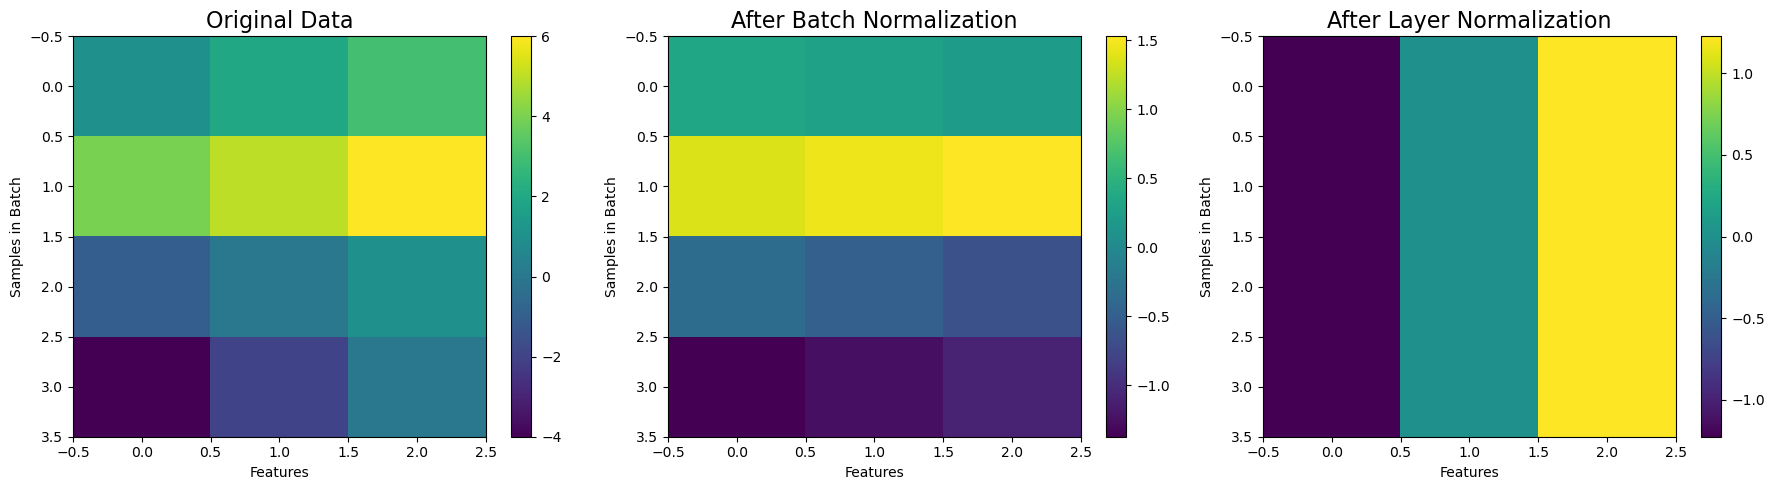

Batch Normalization後の各特徴量の平均 (列ごと): [0. 0. 0.]
Layer Normalization後の各サンプルの平均 (行ごと): [0. 0. 0. 0.]


In [10]:
def visualize_normalization():
    # 4サンプル、各サンプルは3つの特徴量を持つミニバッチを想定
    # (batch_size, num_features)
    X = np.array([
        [1, 2, 3],     # Sample 1
        [4, 5, 6],     # Sample 2
        [-1, 0, 1],    # Sample 3
        [-4, -2, 0]    # Sample 4
    ], dtype=np.float32)
    
    # --- Batch Normalization ---
    # バッチ方向(axis=0)で統計量を計算
    mu_batch = np.mean(X, axis=0)
    var_batch = np.var(X, axis=0)
    X_bn = (X - mu_batch) / np.sqrt(var_batch + 1e-5)
    
    # --- Layer Normalization ---
    # 特徴量方向(axis=1)で統計量を計算
    mu_layer = np.mean(X, axis=1, keepdims=True)
    var_layer = np.var(X, axis=1, keepdims=True)
    X_ln = (X - mu_layer) / np.sqrt(var_layer + 1e-5)
    
    
    # 可視化
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 元のデータ
    im0 = axes[0].imshow(X, cmap='viridis', aspect='auto')
    axes[0].set_title("Original Data", fontsize=16)
    axes[0].set_xlabel("Features")
    axes[0].set_ylabel("Samples in Batch")
    fig.colorbar(im0, ax=axes[0])
    
    # Batch Normalization後
    im1 = axes[1].imshow(X_bn, cmap='viridis', aspect='auto')
    axes[1].set_title("After Batch Normalization", fontsize=16)
    axes[1].set_xlabel("Features")
    axes[1].set_ylabel("Samples in Batch")
    fig.colorbar(im1, ax=axes[1])
    
    # Layer Normalization後
    im2 = axes[2].imshow(X_ln, cmap='viridis', aspect='auto')
    axes[2].set_title("After Layer Normalization", fontsize=16)
    axes[2].set_xlabel("Features")
    axes[2].set_ylabel("Samples in Batch")
    fig.colorbar(im2, ax=axes[2])
    
    plt.tight_layout()
    plt.show()

    print("Batch Normalization後の各特徴量の平均 (列ごと):", np.mean(X_bn, axis=0).round(2))
    print("Layer Normalization後の各サンプルの平均 (行ごと):", np.mean(X_ln, axis=1).round(2))

visualize_normalization()

## 5. まとめと実践的なガイドライン

上の可視化結果は、BNとLNの計算対象の違いを明確に示しています。
*   **Batch Normalization**は、**特徴ごと（列ごと）**に平均が0、分散が1になるように正規化します。
*   **Layer Normalization**は、**サンプルごと（行ごと）**に平均が0、分散が1になるように正規化します。

この違いから、以下のような使い分けのガイドラインが導かれます。

| 手法 | 主な用途 | 長所 | 短所 |
| :--- | :--- | :--- | :--- |
| **Batch Normalization** | CNN、MLP（画像系タスク） | 強力な性能、学習の高速化 | 小さいバッチサイズに弱い、RNN/Transformerに不向き |
| **Layer Normalization** | RNN、Transformer（系列データ系タスク）| バッチサイズに非依存、系列データに適用可能 | CNNではBNほどの性能が出ないことが多い |

**実践的な選択フロー:**
1.  **画像認識など、CNNベースのモデルを扱う場合**は、**Batch Normalization**が第一選択肢となります。大きなバッチサイズを確保できる場合に特に強力です。
2.  **自然言語処理など、RNNやTransformerベースのモデルを扱う場合**は、**Layer Normalization**が標準的な選択肢です。
3.  オンライン学習や、非常に大きなモデルでメモリの制約から**バッチサイズを小さくせざるを得ない場合**も、Layer Normalizationが有効な代替案となります。

正規化層は、現代のディープラーニングにおいて、深いネットワークの学習を成功させるための必須コンポーネントと言っても過言ではありません。内部共変量シフトという問題を理解し、タスクに応じて適切な正規化手法を選択することは、安定した学習を実現する上で不可欠です。
